In [2]:
# Import av alle bibliotekene vi trenger for å løse oppgavene
import requests
import os
import pandas as pd
import missingno as msno
import sys

from dotenv import load_dotenv
from pandasql import sqldf
from collections import Counter

src_path = "..\\src"
if src_path not in sys.path:
    sys.path.insert(0, src_path)

src_path_2 = "..\\venv\\Lib\\site-packages"
if src_path_2 not in sys.path:
    sys.path.insert(0, src_path_2)

import functions as fc

# Sett opp utviklingsmiljø
Før vi begynner har vi satt opp utviklingsmiljø. Vi har alle laget hver vår virtual environment og disse gjør at vi kan jobbe hver for oss, uten å påvirke hverandre. 

In [3]:
# Oppgave 1: Sett opp utviklingsmiljø.

print("Utviklingsmiljøet er klart!")

Utviklingsmiljøet er klart!


# Datainnsamling

Vi har lastet ned et datasett fra Metrologisk institutt med api. API-en har vi kopiert fra nettsida. Vi har lagret hver får client-ID i en ENV-fil under navnet API-KEY. Denne trengs for å ta i bruk datasettet.

In [4]:
# Laster ned verdiene fra .env file.
load_dotenv()

# Henter Client_id fra .env.
api_key = os.getenv('API_KEY')

# Definerer endpoint og parametere.
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN18700,SN90450',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
    'referencetime': '2024-01-01/2025-01-01',
}
# Lager en HTTP GET request.
r = requests.get(endpoint, parameters, auth=(api_key,''))
# Henter JSON data
json = r.json()

# Skjekker om requesten fungerte og printer ut eventuelle feil.
if r.status_code == 200:
    data = json['data']
    print('Data er hentet fra frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

# Lagrer dataen i en Dataframe i et tabellformat.
df = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row])

df = df.reset_index()


Data er hentet fra frost.met.no!


# Databehandling

### Forstå data

For å få et bedre innblikk i hva vi har data om har vi valgt å printe noen av de første av linjene i datasettet og sjekket etter mangler.

In [5]:
# .head(15) printer ut de femten første linjene av datasettet.   
df.head(15)

,index,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,0,mean(air_temperature P1D),-4.9,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2024-01-01T00:00:00.000Z,SN18700:0
1,1,mean(air_temperature P1D),-3.8,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,NaN,2024-01-01T00:00:00.000Z,SN18700:0
2,2,sum(precipitation_amount P1D),10.4,mm,NaN,PT18H,P1D,0,C,2,NaN,2024-01-01T00:00:00.000Z,SN18700:0
3,3,sum(precipitation_amount P1D),6.3,mm,NaN,PT6H,P1D,0,C,2,0.0,2024-01-01T00:00:00.000Z,SN18700:0
4,4,mean(wind_speed P1D),6.9,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2024-01-01T00:00:00.000Z,SN18700:0
5,0,mean(air_temperature P1D),-7.4,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2024-01-02T00:00:00.000Z,SN18700:0
6,1,mean(air_temperature P1D),-5.3,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,NaN,2024-01-02T00:00:00.000Z,SN18700:0
7,2,sum(precipitation_amount P1D),3.1,mm,NaN,PT18H,P1D,0,C,2,NaN,2024-01-02T00:00:00.000Z,SN18700:0
8,3,sum(precipitation_amount P1D),6.4,mm,NaN,PT6H,P1D,0,C,2,0.0,2024-01-02T00:00:00.000Z,SN18700:0
9,4,mean(wind_speed P1D),6.3,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2024-01-02T00:00:00.000Z,SN18700:0


In [6]:
# .shape printer ut hvor mange rader og rekker vi har.
print('Shape', df.shape)

Shape (3660, 13)


index                     0
elementId                 0
value                     0
unit                      0
level                  1464
timeOffset                0
timeResolution            0
timeSeriesId              0
performanceCategory       0
exposureCategory          0
qualityCode            1467
referenceTime             0
sourceId                  0
dtype: int64
Empty DataFrame
Columns: [index, elementId, value, unit, level, timeOffset, timeResolution, timeSeriesId, performanceCategory, exposureCategory, qualityCode, referenceTime, sourceId]
Index: []


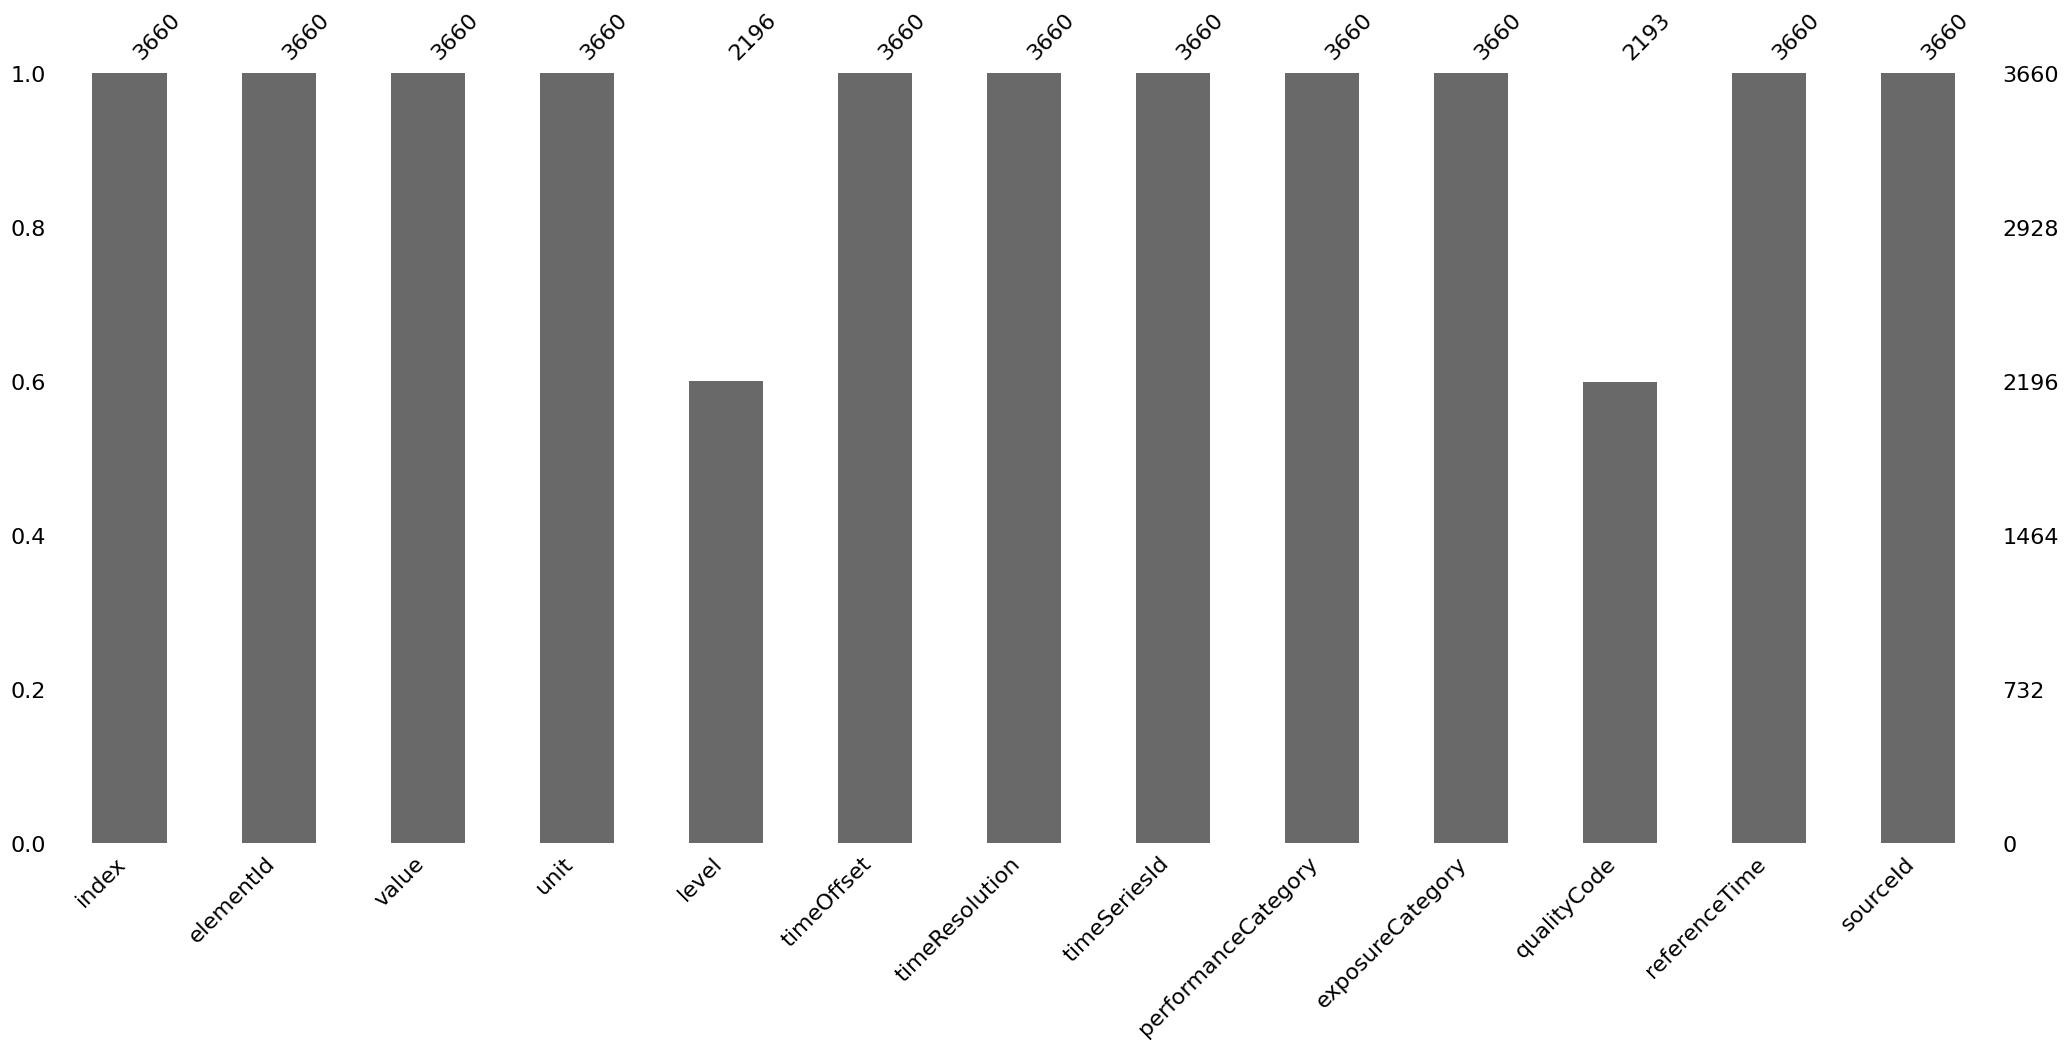

In [7]:
# Finner ut om vi om vi mangler noen verdier.
fc.missing_numbers(df, 'unit')

### Utvalg
Etter vi har blitt litt bedre kjent med dataen, har vi valgt å gå videre med bare fem av kolonnene. Vi har tatt med elementId, value, unit, timeOffset og referenceTime. Dette er kolonner som ikke mangler data og som vi lett forstår innholdet av.

Vi har så printet ut et utvalg av forskjellige linjer for å bli kjent med hvordan datasettet er satt opp. Vi har også printet ut informasjon om datatypene og finnet ut hva de ulike kolonnene med datatypen "object" inneholder. Så har vi sjekket etter duplikater.

In [8]:
# Lager en ny dataframe med utvalgte atributter.
sub_df = df[["elementId", "value", "unit", "timeOffset", "referenceTime"]]
sub_df.head()

,elementId,value,unit,timeOffset,referenceTime
0,mean(air_temperature P1D),-4.9,degC,PT0H,2024-01-01T00:00:00.000Z
1,mean(air_temperature P1D),-3.8,degC,PT6H,2024-01-01T00:00:00.000Z
2,sum(precipitation_amount P1D),10.4,mm,PT18H,2024-01-01T00:00:00.000Z
3,sum(precipitation_amount P1D),6.3,mm,PT6H,2024-01-01T00:00:00.000Z
4,mean(wind_speed P1D),6.9,m/s,PT0H,2024-01-01T00:00:00.000Z


In [9]:
sub_df.tail()

,elementId,value,unit,timeOffset,referenceTime
3655,mean(air_temperature P1D),-1.3,degC,PT0H,2024-12-31T00:00:00.000Z
3656,mean(air_temperature P1D),0.1,degC,PT6H,2024-12-31T00:00:00.000Z
3657,sum(precipitation_amount P1D),4.2,mm,PT18H,2024-12-31T00:00:00.000Z
3658,sum(precipitation_amount P1D),14.9,mm,PT6H,2024-12-31T00:00:00.000Z
3659,mean(wind_speed P1D),4.4,m/s,PT0H,2024-12-31T00:00:00.000Z


In [10]:
sub_df.sample(10)

,elementId,value,unit,timeOffset,referenceTime
2036,mean(air_temperature P1D),-5.1,degC,PT6H,2024-02-11T00:00:00.000Z
1923,sum(precipitation_amount P1D),0.0,mm,PT6H,2024-01-19T00:00:00.000Z
1950,mean(air_temperature P1D),-5.5,degC,PT0H,2024-01-25T00:00:00.000Z
2874,mean(wind_speed P1D),1.9,m/s,PT0H,2024-07-27T00:00:00.000Z
3129,mean(wind_speed P1D),2.4,m/s,PT0H,2024-09-16T00:00:00.000Z
2833,sum(precipitation_amount P1D),0.0,mm,PT6H,2024-07-19T00:00:00.000Z
2762,sum(precipitation_amount P1D),0.0,mm,PT18H,2024-07-05T00:00:00.000Z
1196,mean(air_temperature P1D),14.5,degC,PT6H,2024-08-27T00:00:00.000Z
378,sum(precipitation_amount P1D),24.3,mm,PT6H,2024-03-16T00:00:00.000Z
2993,sum(precipitation_amount P1D),12.8,mm,PT6H,2024-08-20T00:00:00.000Z


In [11]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   elementId      3660 non-null   object 
 1   value          3660 non-null   float64
 2   unit           3660 non-null   object 
 3   timeOffset     3660 non-null   object 
 4   referenceTime  3660 non-null   object 
dtypes: float64(1), object(4)
memory usage: 143.1+ KB


In [12]:
# Finner de ulike elementIdene og legger de i en liste
elementId = []

for i in sub_df['elementId']:
    if i not in elementId:
        elementId.append(i)
print('De ulike elementIdene er: ', elementId)


# Finner de ulike unitene og legger de i en liste
unit = []

for i in sub_df['unit']:
    if i not in unit:
        unit.append(i)
print('De ulike unitene er: ', unit)


# Finner de ulike timeOffset og legger de i en liste
timeOffset = []

for i in sub_df['timeOffset']:
    if i not in timeOffset:
        timeOffset.append(i)
print('De ulike timeOffset er: ', timeOffset)

De ulike elementIdene er:  ['mean(air_temperature P1D)', 'sum(precipitation_amount P1D)', 'mean(wind_speed P1D)']
De ulike unitene er:  ['degC', 'mm', 'm/s']
De ulike timeOffset er:  ['PT0H', 'PT6H', 'PT18H']


Så sjekker vi om datasettet har noen duplikater. 

In [13]:
# Skjekker om vi har noen duplikater i datasettet
count_duplicates = sub_df.duplicated().sum()
print("Antall duplikater:", count_duplicates)

find_duplicates = sub_df[sub_df.duplicated()]

count_days = Counter(sub_df['referenceTime'])

print(count_days)

print(max(count_days.values()))
print(min(count_days.values()))

Antall duplikater: 113
Counter({'2024-01-01T00:00:00.000Z': 10, '2024-01-02T00:00:00.000Z': 10, '2024-01-03T00:00:00.000Z': 10, '2024-01-04T00:00:00.000Z': 10, '2024-01-05T00:00:00.000Z': 10, '2024-01-06T00:00:00.000Z': 10, '2024-01-07T00:00:00.000Z': 10, '2024-01-08T00:00:00.000Z': 10, '2024-01-09T00:00:00.000Z': 10, '2024-01-10T00:00:00.000Z': 10, '2024-01-11T00:00:00.000Z': 10, '2024-01-12T00:00:00.000Z': 10, '2024-01-13T00:00:00.000Z': 10, '2024-01-14T00:00:00.000Z': 10, '2024-01-15T00:00:00.000Z': 10, '2024-01-16T00:00:00.000Z': 10, '2024-01-17T00:00:00.000Z': 10, '2024-01-18T00:00:00.000Z': 10, '2024-01-19T00:00:00.000Z': 10, '2024-01-20T00:00:00.000Z': 10, '2024-01-21T00:00:00.000Z': 10, '2024-01-22T00:00:00.000Z': 10, '2024-01-23T00:00:00.000Z': 10, '2024-01-24T00:00:00.000Z': 10, '2024-01-25T00:00:00.000Z': 10, '2024-01-26T00:00:00.000Z': 10, '2024-01-27T00:00:00.000Z': 10, '2024-01-28T00:00:00.000Z': 10, '2024-01-29T00:00:00.000Z': 10, '2024-01-30T00:00:00.000Z': 10, '2024-01

Det vises at datasettet har flere dukpikater, men det stemmer ikke helt. Alle referansetidene skal skje ti ganger og det stemmer gjennom hele datasettet. Det tyder på at de samme referansetidene og tidsforskyvningene av og til har samme verdi.

Etter vi har blitt kjent med datasettet har vi valgt å skifte noen kolonnenavnene til norsk. Dette er de kolonnene vi kommer til å trenge videre i analysen og å gi norske navn gav oss lettere forståelse for hva vi jobbet med.

In [14]:
# Gir nye navn til noen av kolonnene til det nye dataframen. 
sub_df.rename(columns={"value": "verdi", "timeOffset" : "tidsforskyvning", "referenceTime": "referansetid"}, inplace = True)
sub_df.head()

C:\Users\sofie\AppData\Local\Temp\ipykernel_31056\1062277244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.rename(columns={"value": "verdi", "timeOffset" : "tidsforskyvning", "referenceTime": "referansetid"}, inplace = True)


,elementId,verdi,unit,tidsforskyvning,referansetid
0,mean(air_temperature P1D),-4.9,degC,PT0H,2024-01-01T00:00:00.000Z
1,mean(air_temperature P1D),-3.8,degC,PT6H,2024-01-01T00:00:00.000Z
2,sum(precipitation_amount P1D),10.4,mm,PT18H,2024-01-01T00:00:00.000Z
3,sum(precipitation_amount P1D),6.3,mm,PT6H,2024-01-01T00:00:00.000Z
4,mean(wind_speed P1D),6.9,m/s,PT0H,2024-01-01T00:00:00.000Z


### Dele inn i mindre datasett
Etter vi har blitt bedre kjent med størrelsen og innholdet i datasettet har vi valgt å dele det inn i noen mindre datasettet.

Datasettet inneholder tre ulike elementtyper. Vi har valgt å dele datasettet inn i disse tre og lagre de i egne CSV-filer. Siden vi er tre på gruppa har vi da et datasett hver å jobbe med i resten av analysen.

In [15]:
# Henter ut bare temperatur dataene.
query_temperature = f"""
    SELECT verdi, tidsforskyvning, referansetid
    FROM sub_df
    WHERE elementId LIKE 'mean(air_temperature P1D)'
    """

temperature = sqldf(query_temperature)
print(temperature)

# Legger temperatur dataene til en egen csv-fil.
temperature.to_csv('../data/temperature.csv', index=False)


# Bruker SQL spørringer til å hente ut bare nedbør dataene.
query_precipitation = f"""
    SELECT verdi, tidsforskyvning, referansetid
    FROM sub_df
    WHERE elementId LIKE 'sum(precipitation_amount P1D)'
    """

precipitation = sqldf(query_precipitation)
print(precipitation)

# Legger nedbør dataene til en egen csv-fil.
precipitation.to_csv('../data/precipitation.csv', index=False)


# Henter ut bare vind dataene.
query_wind = f"""
    SELECT verdi, tidsforskyvning, referansetid
    FROM sub_df
    WHERE elementId LIKE 'mean(wind_speed P1D)'
    """
wind = sqldf(query_wind)
print(wind)

# Legger vind dataene til en egen csv-fil.
wind.to_csv('../data/wind.csv', index=False)

      verdi tidsforskyvning              referansetid
0      -4.9            PT0H  2024-01-01T00:00:00.000Z
1      -3.8            PT6H  2024-01-01T00:00:00.000Z
2      -7.4            PT0H  2024-01-02T00:00:00.000Z
3      -5.3            PT6H  2024-01-02T00:00:00.000Z
4      -8.5            PT0H  2024-01-03T00:00:00.000Z
...     ...             ...                       ...
1459    2.8            PT6H  2024-12-29T00:00:00.000Z
1460    0.2            PT0H  2024-12-30T00:00:00.000Z
1461    1.0            PT6H  2024-12-30T00:00:00.000Z
1462   -1.3            PT0H  2024-12-31T00:00:00.000Z
1463    0.1            PT6H  2024-12-31T00:00:00.000Z

[1464 rows x 3 columns]
      verdi tidsforskyvning              referansetid
0      10.4           PT18H  2024-01-01T00:00:00.000Z
1       6.3            PT6H  2024-01-01T00:00:00.000Z
2       3.1           PT18H  2024-01-02T00:00:00.000Z
3       6.4            PT6H  2024-01-02T00:00:00.000Z
4       1.2           PT18H  2024-01-03T00:00:00.000Z
...